# Script d'appariement des données CHIMERE 

## Description

- Croisement des données CHIMERE (données de qualité d'air simulée) avec les données mesurées par le CSBT (dans différent batiment en France) 
- Input : 
    - Fichier xlsx du CSBT contenant les identifiants et coordonées de différent batiments, ainsi que les différentes dates de campagne de mesure 
    - Fichier CHIMERE contenant la concentration de poluant simulés par jour sur toute la France. Les données simulées sont stockées dans une grille de coordonées, avec un échantillonage de 4km²

- Output : 
    - Data farm contenant les identifiants et coordonées de différent batiments, ainsi que les différentes dates de campagne de mesures et les concentrations moyennes, médianes, minimales et maximales des différents poluant pour les dates de comapgne de mesures conrespondantes.





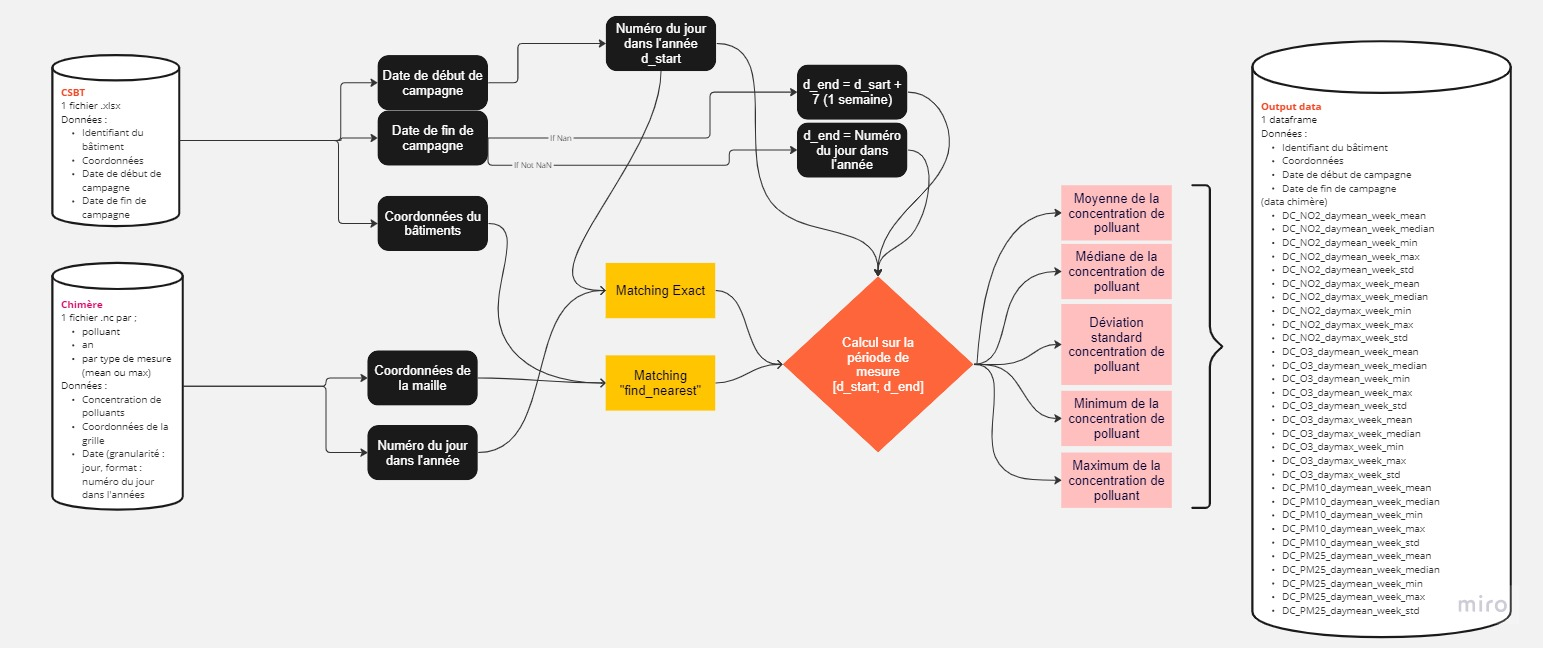

In [1]:
%run inits_python.py

In [2]:
from datetime import datetime

In [3]:
import seaborn as sns

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print('value to find', value)
    #print('nereast value',array[idx])
    return idx,array[idx]

def find_index_day(dt64, strtype="%Y-%m-%d %H:%M:%S"):

    numero = datetime.strptime(str(dt64),strtype).timetuple().tm_yday - 1 #python count from 0 
    return numero


In [5]:
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap

In [6]:
polution_wanted = ['NO2','O3','PM10','PM25']
values = ['daymean', 'daymax']
years = ['2013','2014','2015','2016','2017','2018','2019', '2020','2021']

## CSTB DATA 

In [7]:
df_bati = pd.read_excel('API2BUILD_COORD_DATES_BATI.xlsx')

In [8]:
df_bati.describe()

,Longitude,Latitude,Date_debut_enquete,Date_fin_enquete
count,1106.000000,1106.000000,1106,977
mean,2.597242,47.125371,2019-02-27 20:03:02.278480896,2019-08-31 03:05:42.681678592
min,-4.760333,42.693349,2013-06-17 00:00:00,2013-06-21 00:00:00
25%,0.887085,45.522592,2015-09-25 06:00:00,2016-06-10 00:00:00
50%,2.391740,47.790242,2021-01-18 00:00:00,2021-03-09 00:00:00
75%,4.899437,48.840617,2021-11-24 18:00:00,2022-03-17 00:00:00
max,7.870720,50.952477,2023-02-22 00:00:00,2023-03-01 00:00:00
std,2.901869,2.115402,NaN,NaN


In [9]:
df_bati.Date_fin_enquete

0             NaT
1             NaT
2             NaT
3             NaT
4             NaT
          ...    
1101   2022-11-15
1102   2022-09-09
1103   2022-09-08
1104   2022-04-11
1105   2022-08-04
Name: Date_fin_enquete, Length: 1106, dtype: datetime64[ns]

## Chimère data

In [10]:
data_farm_to_add=[]

for pol in polution_wanted :
    for val in values :
        if pol == 'PM10' or pol == 'PM25' :
            if val == 'daymax' : 
                continue
        for y in years : 
            # Open Chimère data
            print('OPEN CHIMERE DATA')
            if int(y)<2018 : 
                file = '../../../data/DailyGriddedData_'+y+'.FRA03/INERIS.REANALYSED.FRA03.'+y+'.'+pol+'.'+val+'.2gis.nc' 
            else : 
                file = '../../../data/DailyGriddedData_'+y+'.FRA02/INERIS.REANALYSED.FRA02.'+y+'.'+pol+'.'+val+'.2gis.nc' 
            #mention the path to the downloaded file
            print('.....'+file)
            data = Dataset(file, mode='r') # read the data 
            print(type(data)) # print the type of the data 
            print(data.variables.keys()) # print the variables in the data
            #print(data.variables['Times'])
            
            lats = data.variables['lat'][:]  
            longs = data.variables['lon'][:]
            time = data.variables['Times'][:]
            polution=data.variables[pol][:]

            # FIND POLUTION EXTERIOR AND MATCH TO DATE AND POSITION OF CSBT CAMPAIGN
            pol_mean_week = []
            pol_median_week = []
            pol_max_week = []
            pol_min_week = []
            pol_std_week = []
            
            lats_bati = []
            longs_bati = []
            date_debut=[]
            date_fin=[]
            iden_bati=[]
            
            for date in df_bati.Date_debut_enquete: 

                if (date.year == int(y)):

                    df = df_bati[df_bati.Date_debut_enquete==date].copy()
                    
                    for i,L in enumerate(df.Longitude):
                        iden_bati.append(df.Identifiant.values[i])
                        lats_bati.append(df.Latitude.values[i])
                        longs_bati.append(L)
                        date_debut.append(df.Date_debut_enquete.values[i])
                        date_fin.append(df.Date_fin_enquete.values[i])
                
                        numero_day=find_index_day(date)
                    
                        if pd.isnull(df.Date_fin_enquete.values[i])==True: 
                            numero_day_fin = numero_day +1
                        else : 
                            numero_day_fin = find_index_day(df.Date_fin_enquete.values[i], 
                                                            strtype="%Y-%m-%dT00:00:00.000000000")
                        
                            
                        longi = find_nearest(longs,L)[0]
                        lati = find_nearest(lats,df.Latitude.values[i])[0]
                        
                        pol_mean_week.append(np.mean(polution[numero_day:numero_day_fin, lati,longi]))
                        pol_max_week.append(np.max(polution[numero_day:numero_day_fin, lati,longi]))
                        pol_min_week.append(np.min(polution[numero_day:numero_day_fin, lati,longi]))
                        pol_median_week.append(np.ma.median(polution[numero_day:numero_day_fin, lati,longi]))
                        pol_std_week.append(np.std(polution[numero_day:numero_day_fin, lati,longi]))
                        
            d = {'Identifiant':iden_bati,
                        'Longitude':longs_bati,
                         'Latitude':lats_bati,
                         'Date_debut_enquete':date_debut,
                         'Date_fin_enquete':date_fin,
                         'DC_'+pol+'_'+val+'_campaign_mean':pol_mean_week,
                         'DC_'+pol+'_'+val+'_campaign_median':pol_median_week,
                         'DC_'+pol+'_'+val+'_campaign_min':pol_min_week,
                         'DC_'+pol+'_'+val+'_campaign_max':pol_max_week,
                         'DC_'+pol+'_'+val+'_campaign_std':pol_std_week
                 
                }

            df = pd.DataFrame(d)
            df.set_index("Identifiant")
            data_farm_to_add.append(df)

OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2013.FRA03/INERIS.REANALYSED.FRA03.2013.NO2.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['NO2', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2014.FRA03/INERIS.REANALYSED.FRA03.2014.NO2.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['NO2', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2015.FRA03/INERIS.REANALYSED.FRA03.2015.NO2.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['NO2', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2016.FRA03/INERIS.REANALYSED.FRA03.2016.NO2.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['NO2', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2017.FRA03/INERIS.REANALYSED.FRA03.2017.NO2.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['NO2', 'Times', 'Tim

OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2018.FRA02/INERIS.REANALYSED.FRA02.2018.PM10.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['PM10', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2019.FRA02/INERIS.REANALYSED.FRA02.2019.PM10.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['PM10', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2020.FRA02/INERIS.REANALYSED.FRA02.2020.PM10.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['PM10', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2021.FRA02/INERIS.REANALYSED.FRA02.2021.PM10.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['PM10', 'Times', 'Times_bnds', 'lat', 'lon'])
OPEN CHIMERE DATA
......./../../data/DailyGriddedData_2013.FRA03/INERIS.REANALYSED.FRA03.2013.PM25.daymean.2gis.nc
<class 'netCDF4._netCDF4.Dataset'>
dict_keys(['PM25', 'Ti

In [11]:
# Create basemap for visualization 
mp = Basemap(projection='merc',
             llcrnrlon=np.min(longs),   # lower longitude
             llcrnrlat=np.min(lats),    # lower latitude
             urcrnrlon=np.max(longs),   # uppper longitude
             urcrnrlat=np.max(lats),   # uppper latitude
            resolution = 'i')

In [12]:
concat_polution = pd.concat(data_farm_to_add, axis=0)


In [13]:
#for c in concat_polution.columns : 
 #   print("'"+c+"'" +":'sum'")

In [14]:
# Concatenation 
concat_polution = pd.concat(data_farm_to_add, axis=0)
aggregation_functions = {'DC_NO2_daymean_campaign_mean':'sum',
                        'DC_NO2_daymean_campaign_median':'sum',
                        'DC_NO2_daymean_campaign_min':'sum',
                        'DC_NO2_daymean_campaign_max':'sum',
                        'DC_NO2_daymean_campaign_std':'sum',
                        'DC_NO2_daymax_campaign_mean':'sum',
                        'DC_NO2_daymax_campaign_median':'sum',
                        'DC_NO2_daymax_campaign_min':'sum',
                        'DC_NO2_daymax_campaign_max':'sum',
                        'DC_NO2_daymax_campaign_std':'sum',
                        'DC_O3_daymean_campaign_mean':'sum',
                        'DC_O3_daymean_campaign_median':'sum',
                        'DC_O3_daymean_campaign_min':'sum',
                        'DC_O3_daymean_campaign_max':'sum',
                        'DC_O3_daymean_campaign_std':'sum',
                        'DC_O3_daymax_campaign_mean':'sum',
                        'DC_O3_daymax_campaign_median':'sum',
                        'DC_O3_daymax_campaign_min':'sum',
                        'DC_O3_daymax_campaign_max':'sum',
                        'DC_O3_daymax_campaign_std':'sum',
                        'DC_PM10_daymean_campaign_mean':'sum',
                        'DC_PM10_daymean_campaign_median':'sum',
                        'DC_PM10_daymean_campaign_min':'sum',
                        'DC_PM10_daymean_campaign_max':'sum',
                        'DC_PM10_daymean_campaign_std':'sum',
                        'DC_PM25_daymean_campaign_mean':'sum',
                        'DC_PM25_daymean_campaign_median':'sum',
                        'DC_PM25_daymean_campaign_min':'sum',
                        'DC_PM25_daymean_campaign_max':'sum',
                        'DC_PM25_daymean_campaign_std':'sum'}

concat_polution_group = concat_polution.groupby(['Identifiant',
                                                 'Longitude', 
                                                 'Latitude',                                               
                                                 'Date_debut_enquete',
                                                ]).aggregate(aggregation_functions)
final_df = pd.merge(left=df_bati,right=concat_polution_group, 
                    on=['Identifiant','Longitude','Latitude','Date_debut_enquete'], how='outer')

In [15]:
def plot_polution_map(df,pol):
    # MAP DATA
    lon, lat = np.meshgrid(longs,lats)  #this converts coordinates into 2D arrray
    x,y = mp(lon,lat) #mapping them together

    plt.figure(figsize=(31,16)) #figure size 
    plt.title(pol+ ' concentration [ug/m3]')

    # PLOT OPTION  to show frontier
    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()


    bati=mp.scatter(df.Longitude,df.Latitude,
                    c=df[pol], latlon=True,s=40, cmap='jet', marker='o')
    cbar = mp.colorbar(bati ,location='right',pad = '10%') # map information

    plt.show()
    return 




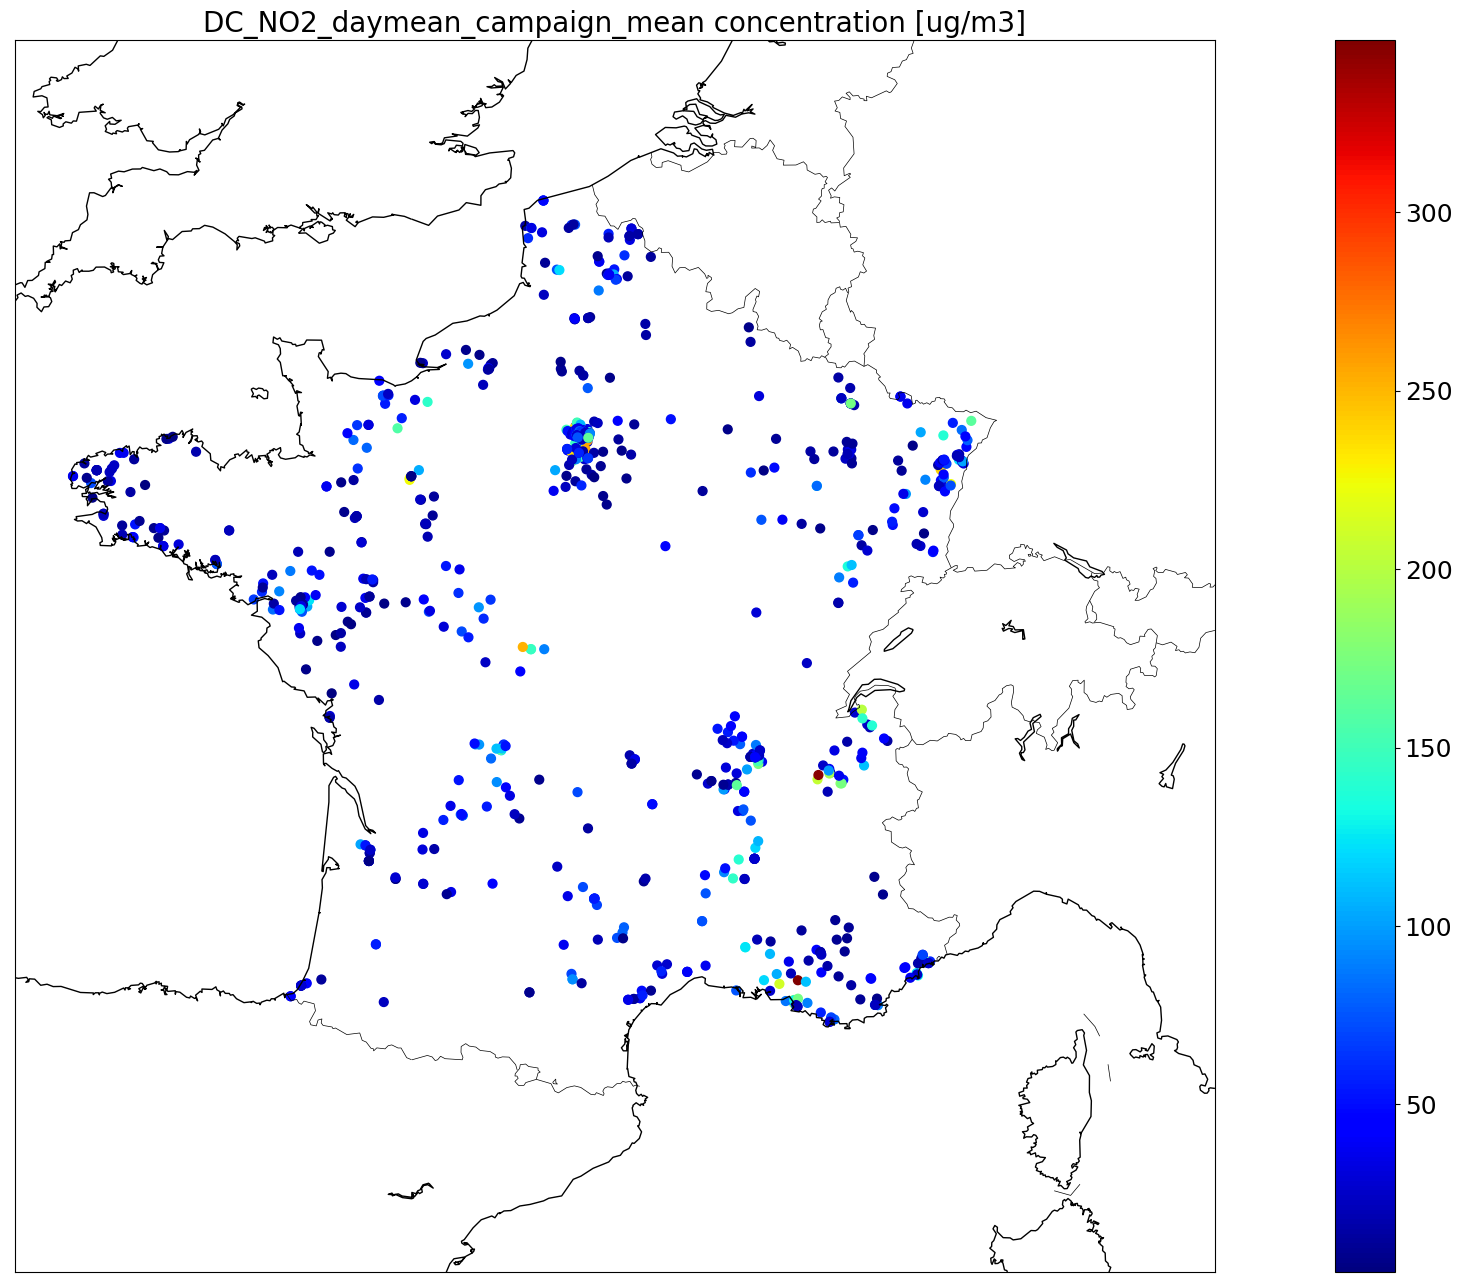

In [16]:
plot_polution_map(df=final_df,pol='DC_NO2_daymean_campaign_mean')

In [17]:
final_df.to_excel("API2BUILD_COORD_DATES_BATI_CHIMERE_CONCENTRATION.xlsx")

<AxesSubplot: xlabel='Date_debut_enquete', ylabel='DC_NO2_daymean_campaign_max'>

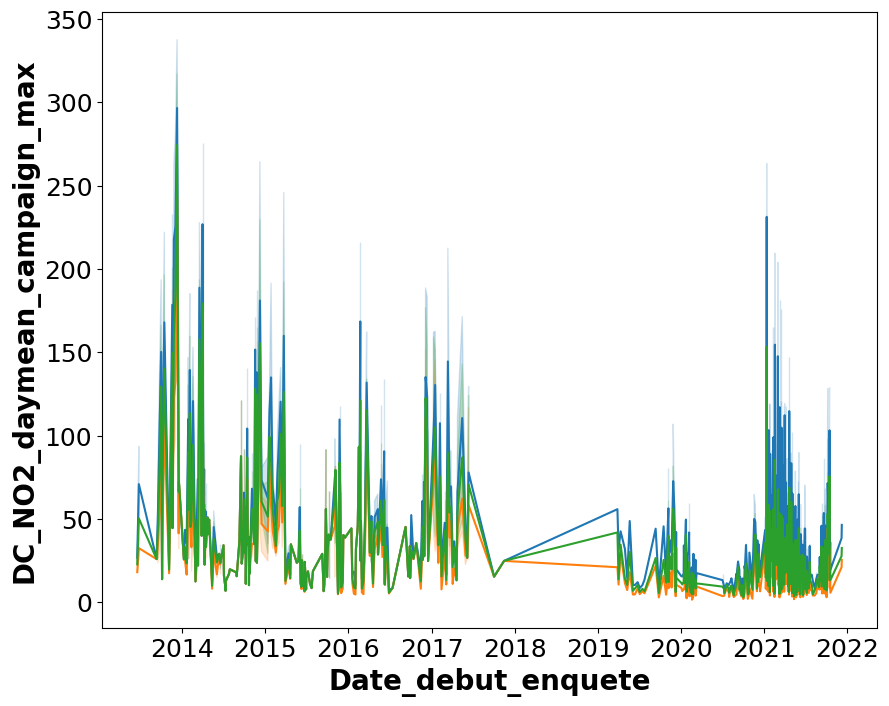

In [24]:
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_NO2_daymean_campaign_max")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_NO2_daymean_campaign_min")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_NO2_daymean_campaign_median")

<AxesSubplot: xlabel='Date_debut_enquete', ylabel='DC_O3_daymean_campaign_max'>

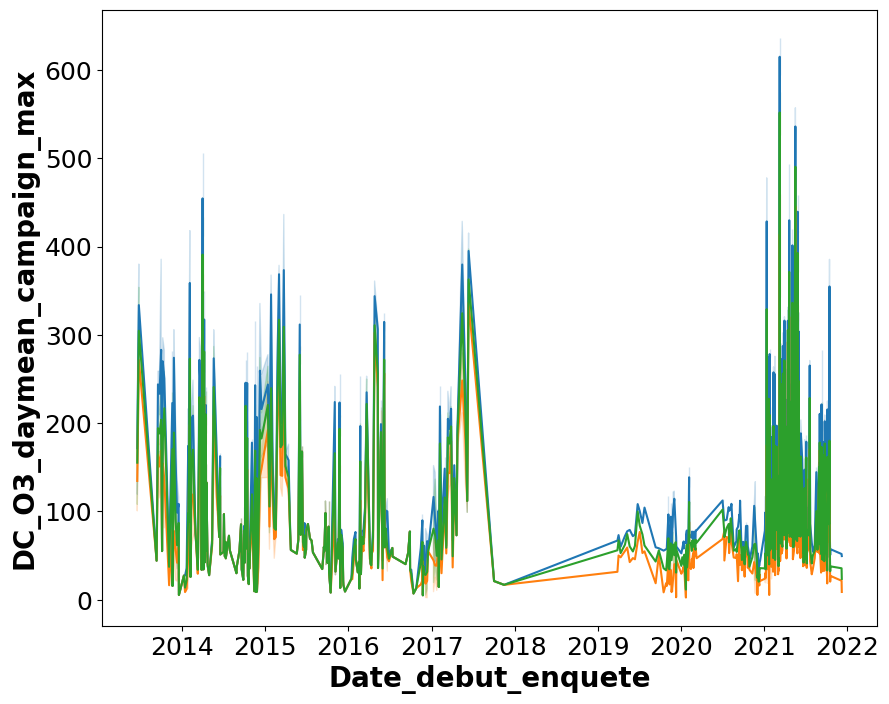

In [25]:
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_O3_daymean_campaign_max")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_O3_daymean_campaign_min")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_O3_daymean_campaign_median")

<AxesSubplot: xlabel='Date_debut_enquete', ylabel='DC_PM25_daymean_campaign_max'>

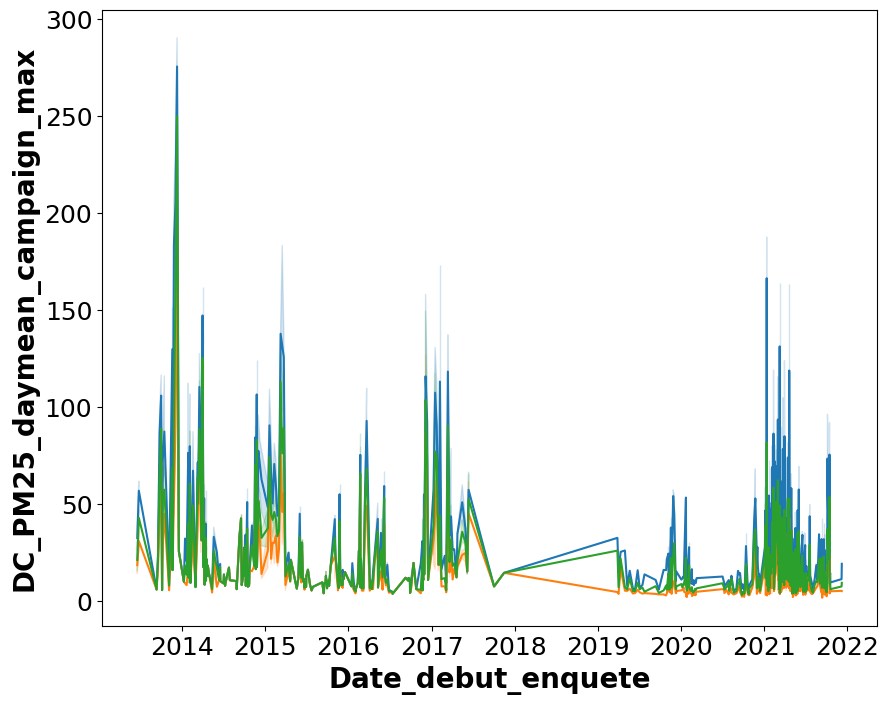

In [26]:
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_PM25_daymean_campaign_max")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_PM25_daymean_campaign_min")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_PM25_daymean_campaign_median")

<AxesSubplot: xlabel='Date_debut_enquete', ylabel='DC_PM10_daymean_campaign_max'>

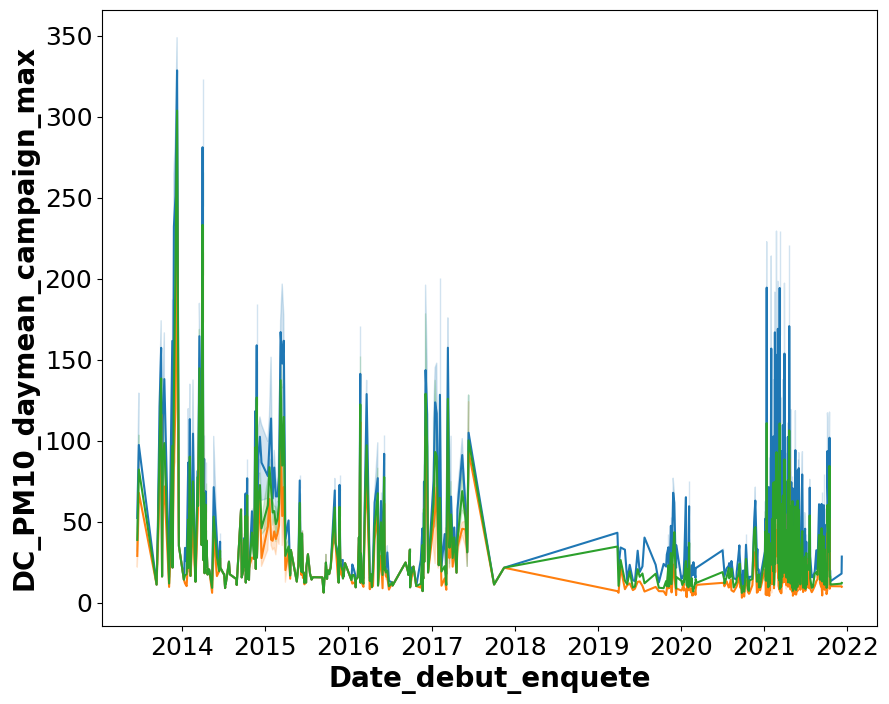

In [27]:
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_PM10_daymean_campaign_max")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_PM10_daymean_campaign_min")
sns.lineplot(data=final_df,  x="Date_debut_enquete", y="DC_PM10_daymean_campaign_median")

In [28]:
df_for_plotting = final_df.copy()
df_for_plotting['Id']=df_for_plotting['Identifiant'].astype(str).str[0]
df_for_plotting=df_for_plotting[df_for_plotting['DC_NO2_daymax_campaign_max'].isnull()==False]

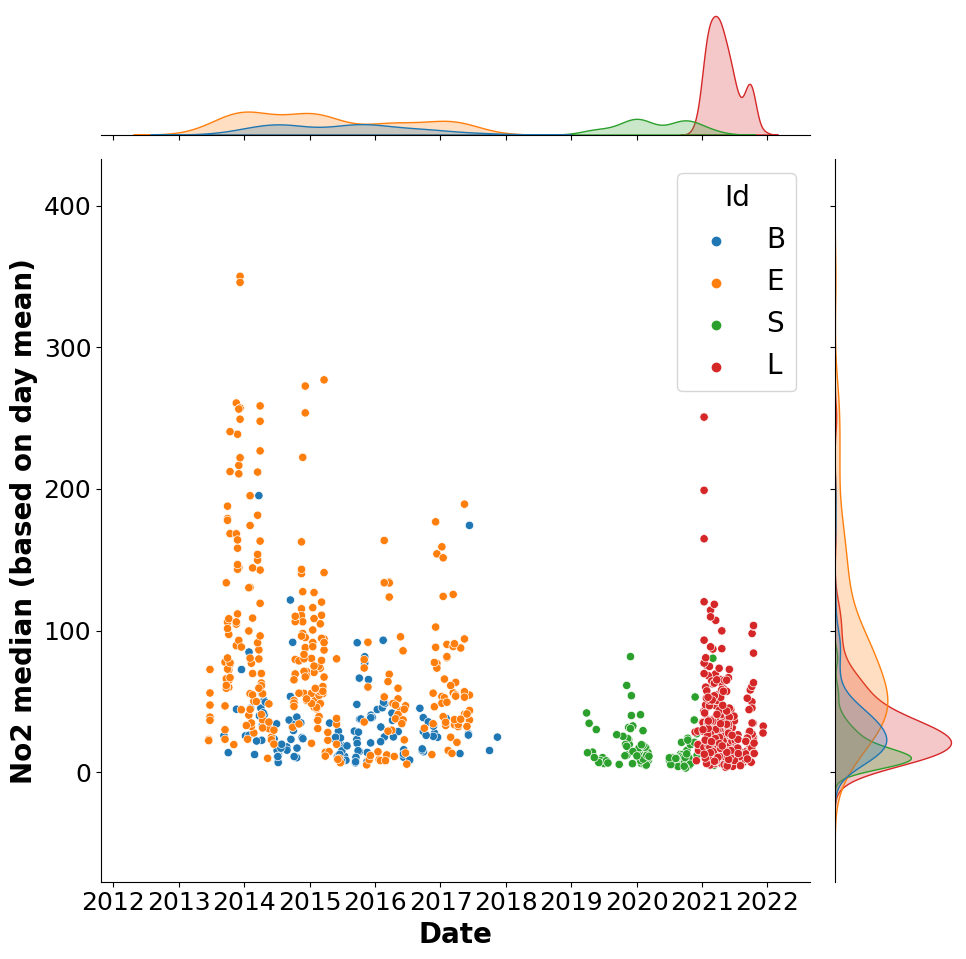

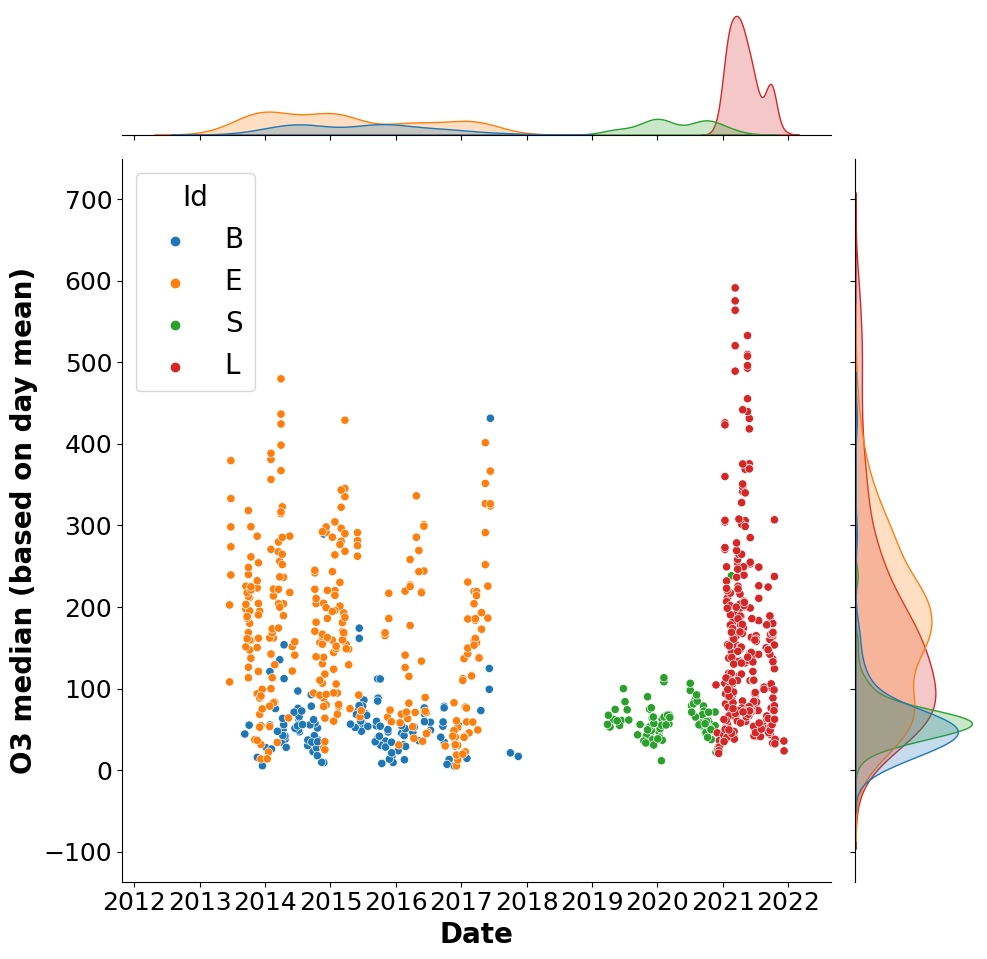

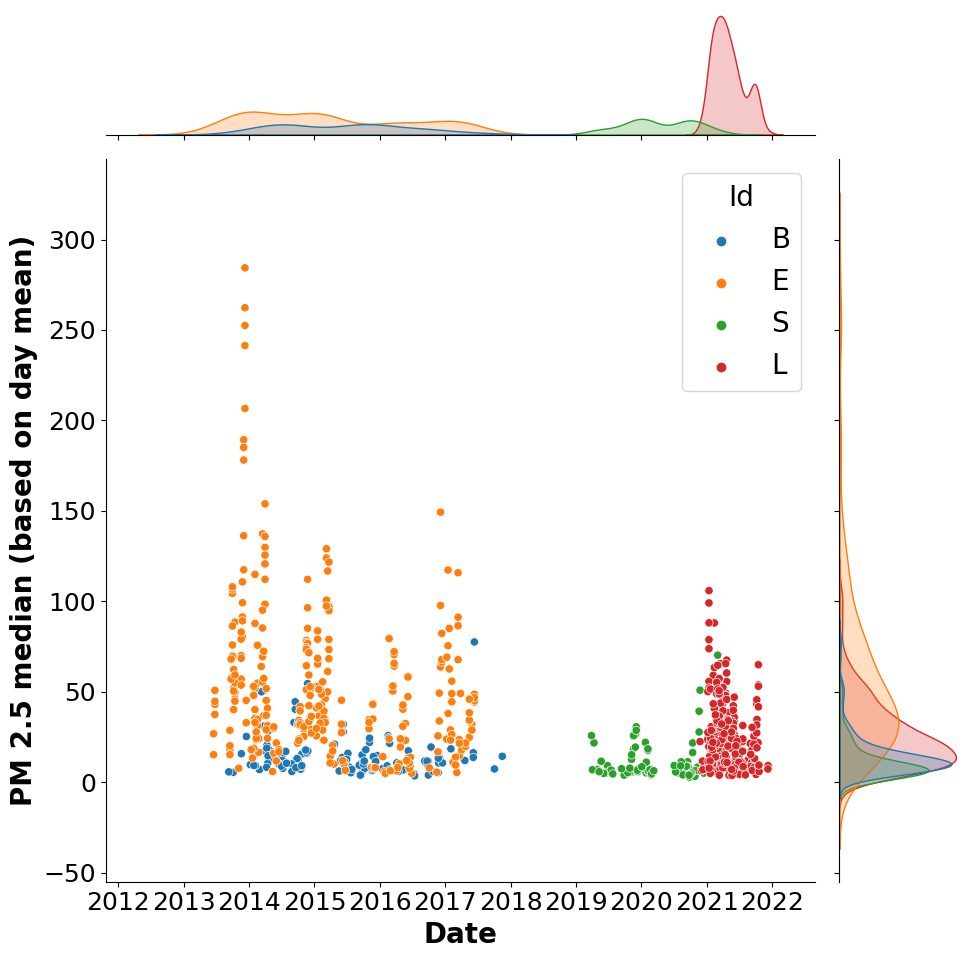

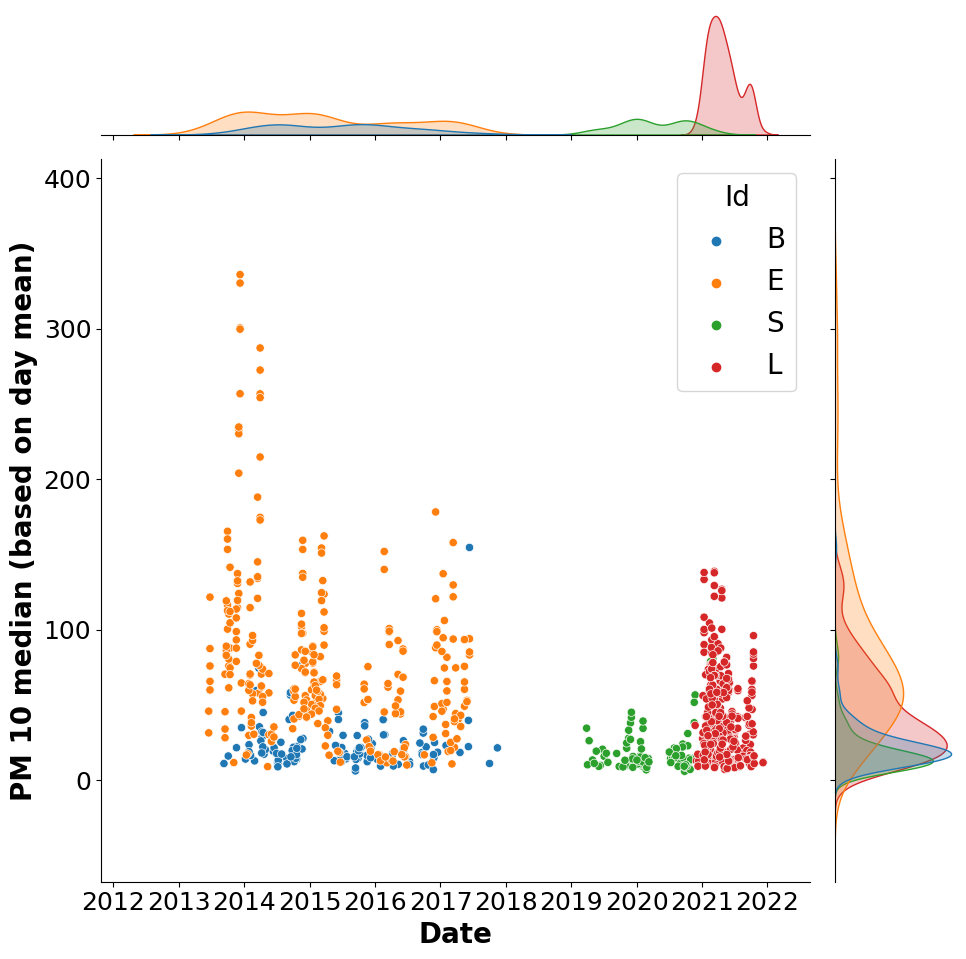

In [29]:

g = sns.jointplot(df_for_plotting,  x="Date_debut_enquete", y="DC_NO2_daymean_campaign_median", hue='Id', height=10)
g.set_axis_labels('Date','No2 median (based on day mean)')

g = sns.jointplot(df_for_plotting,  x="Date_debut_enquete", y="DC_O3_daymean_campaign_median", hue='Id', height=10)
g.set_axis_labels('Date','O3 median (based on day mean)')


g = sns.jointplot(df_for_plotting,  x="Date_debut_enquete", y="DC_PM25_daymean_campaign_median", hue='Id', height=10)
g.set_axis_labels('Date','PM 2.5 median (based on day mean)')

g = sns.jointplot(df_for_plotting,  x="Date_debut_enquete", y="DC_PM10_daymean_campaign_median", hue='Id', height=10)
g.set_axis_labels('Date','PM 10 median (based on day mean)')

